# Import Necessary Libraries

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set TensorFlow backend for segmentation models
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Install segmentation_models package (only needed if not installed)
!pip install segmentation_models

# Import segmentation models library
import segmentation_models as sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.8 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


# Load Images and Masks

In [ ]:
# Function to load images and masks from given folders
def load_data(image_folder, mask_folder):
    images, masks = [], []
    image_filenames = sorted(os.listdir(image_folder))

    for filename in image_filenames:
        img_path = os.path.join(image_folder, filename)
        mask_path = os.path.join(mask_folder, filename)

        if os.path.exists(mask_path):
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Resize images and masks to 128x128
            img = cv2.resize(img, (128, 128)) / 255.0  # Normalize image pixels to [0,1]
            mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)

            # Binarize mask after resizing
            _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
            mask = mask / 255.0  # Normalize mask to [0,1]

            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)

# Define dataset paths
image_folder = "/dataset2/face_crop"
mask_folder = "/dataset2/face_crop_segmentation"

# Load dataset
X, Y = load_data(image_folder, mask_folder)

# Split dataset into training and testing sets (80% test, 20% train)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=42)


# Region Segmentation Using Traditional Techniques

In [3]:
# Function for traditional segmentation using Otsu's thresholding and Canny edge detection
def traditional_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert image to grayscale
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Apply Gaussian blur

    # Otsu's Thresholding
    _, binary_mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Canny Edge Detection
    edges = cv2.Canny(blurred, 100, 200)

    return binary_mask, edges


# Evaluate Traditional Segmentation Performance

In [4]:
# Function to evaluate traditional segmentation using IoU and Dice scores
def evaluate_traditional(images, masks):
    iou_scores, dice_scores = [], []

    for img, true_mask in zip(images, masks):
        pred_mask, _ = traditional_segmentation((img * 255).astype(np.uint8))

        # Convert true mask to binary
        true_mask = (true_mask * 255).astype(np.uint8)
        _, true_mask = cv2.threshold(true_mask, 127, 255, cv2.THRESH_BINARY)

        # Compute IoU and Dice Score
        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()

        iou = intersection / (union + 1e-6)  # Avoid division by zero
        dice = (2. * intersection) / (pred_mask.sum() + true_mask.sum() + 1e-6)

        iou_scores.append(iou)
        dice_scores.append(dice)

    print(f"Traditional Segmentation - IoU: {np.mean(iou_scores):.4f}, Dice: {np.mean(dice_scores):.4f}")


# Visualizing Traditional Segmentation Results

Traditional Segmentation - IoU: 0.2779, Dice: 0.0015


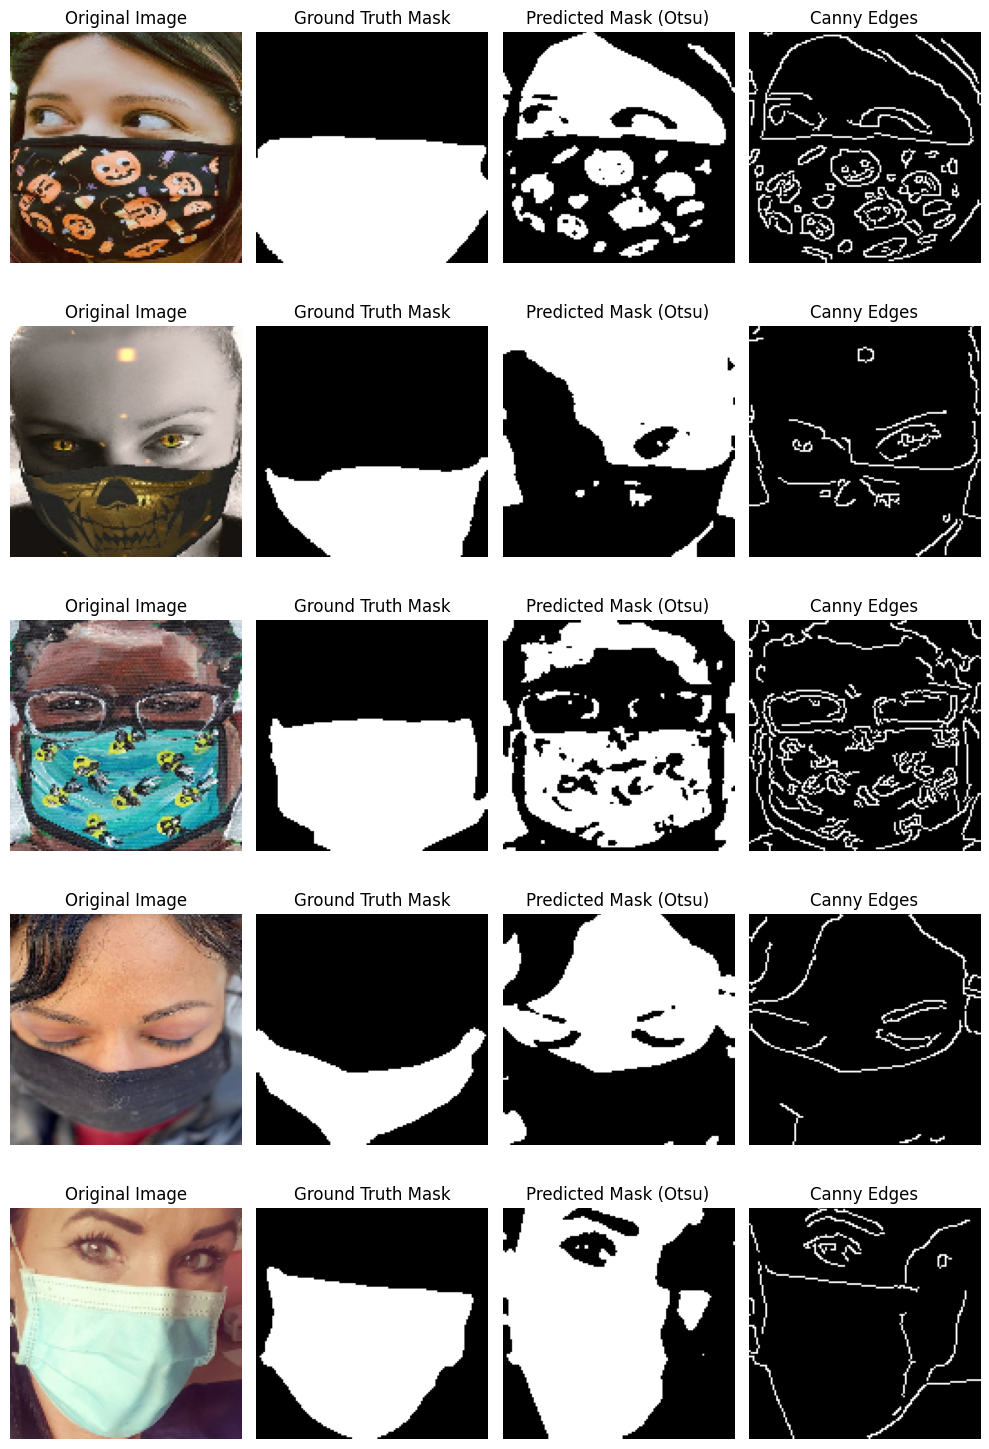

In [5]:
# Function to visualize segmentation results
def visualize_results(images, masks, num_samples=5):
    plt.figure(figsize=(10, num_samples * 3))

    for i in range(num_samples):
        img = (images[i] * 255).astype(np.uint8)
        true_mask = (masks[i] * 255).astype(np.uint8)
        pred_mask, edges = traditional_segmentation(img)

        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(true_mask, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Predicted Mask (Otsu)")
        plt.axis("off")

        plt.subplot(num_samples, 4, i * 4 + 4)
        plt.imshow(edges, cmap="gray")
        plt.title("Canny Edges")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run evaluation and visualization
evaluate_traditional(X_test, Y_test)
visualize_results(X_test, Y_test, num_samples=5)


# Mask Segmentation Using U-Net

In [6]:
# Set backbone for U-Net model
BACKBONE = "resnet50"

# Load U-Net model with a pre-trained encoder
pretrained_unet = sm.Unet(BACKBONE, encoder_weights="imagenet", input_shape=(128, 128, 3), classes=1, activation="sigmoid")

# Compile the model
pretrained_unet.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
pretrained_unet.fit(X_train, Y_train, validation_split=0.2, epochs=10, batch_size=8)


94592056/94592056 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 103s 241ms/step - accuracy: 0.8865 - loss: 0.2825 - val_accuracy: 0.8149 - val_loss: 0.6237
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.9575 - loss: 0.1107 - val_accuracy: 0.7858 - val_loss: 0.5225
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.9640 - loss: 0.0937 - val_accuracy: 0.7803 - val_loss: 0.7636
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.9685 - loss: 0.0827 - val_accuracy: 0.9147 - val_loss: 0.2699
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.9708 - loss: 0.0765 - val_accuracy: 0.9547 - val_loss: 0.1186
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9724 - loss: 0.0716 - val_accuracy: 0.9624 - val_loss: 0.1008
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9750 - loss: 0.0631 - val_accuracy: 0.9591 - val_loss: 0.1040
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━

# Evaluate U-Net Performance

In [7]:
# Function to evaluate U-Net performance
def evaluate_unet(model, images, masks):
    pred_masks = model.predict(images)
    iou_scores, dice_scores = [], []

    for pred_mask, true_mask in zip(pred_masks, masks):
        pred_mask = (pred_mask.squeeze() > 0.5).astype(np.uint8)  # Binarize predicted mask
        true_mask = (true_mask > 0.5).astype(np.uint8)

        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()

        iou = intersection / (union + 1e-6)
        dice = (2. * intersection) / (pred_mask.sum() + true_mask.sum() + 1e-6)

        iou_scores.append(iou)
        dice_scores.append(dice)

    print(f"Pretrained U-Net - IoU: {np.mean(iou_scores):.4f}, Dice: {np.mean(dice_scores):.4f}")


# Visualizing U-Net Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


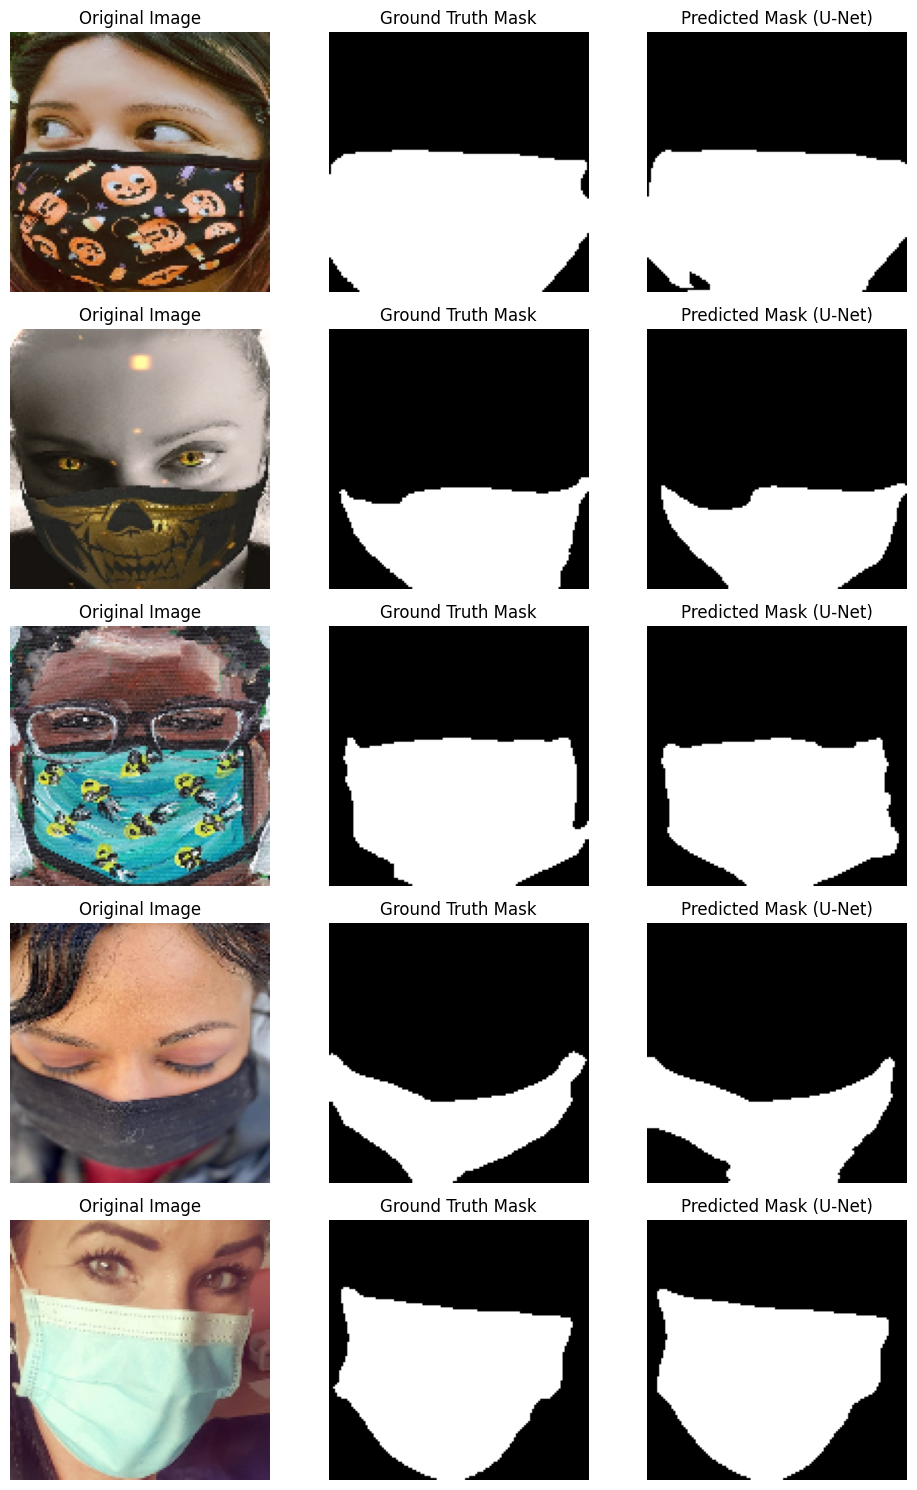

235/235 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step
Pretrained U-Net - IoU: 0.9101, Dice: 0.9476


In [8]:
# Function to visualize U-Net segmentation results
def visualize_results(model, images, masks, num_samples=5):
    pred_masks = model.predict(images) > 0.5

    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        img = (images[i] * 255).astype(np.uint8)
        true_mask = (masks[i] * 255).astype(np.uint8)
        pred_mask = (pred_masks[i] * 255).astype(np.uint8).squeeze()

        axes[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(true_mask, cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred_mask, cmap="gray")
        axes[i, 2].set_title("Predicted Mask (U-Net)")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Run evaluation and visualization for U-Net
visualize_results(pretrained_unet, X_test[:5], Y_test[:5])
evaluate_unet(pretrained_unet, X_test, Y_test)
